# [Полная статья](https://www.tensorflow.org/tutorials/load_data/images?hl=ru)

Во-первых, вы будете использовать высокоуровневые утилиты предварительной обработки Keras (такие как [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) ) и слои (такие как [tf.keras.layers.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) ) для чтения каталога изображений на диске.

Далее вы напишете свой собственный входной конвейер с нуля , используя [tf.data](https://www.tensorflow.org/guide/data?hl=ru).

Наконец, вы загрузите набор данных из большого [каталога](https://www.tensorflow.org/datasets/catalog/overview?hl=ru) , доступного в [TensorFlow Datasets](https://www.tensorflow.org/datasets?hl=ru) .

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.15.0


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

После загрузки (218 МБ) у вас должна быть доступна копия фотографий цветов. Всего 3670 изображений:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Каждый каталог содержит изображения этого типа цветов. Вот несколько роз:

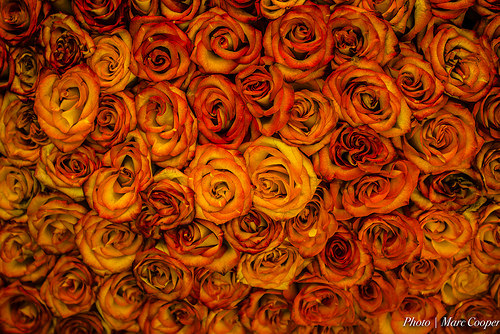

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

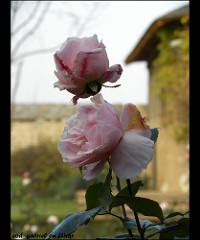

In [ ]:
PIL.Image.open(str(roses[1]))

Давайте загрузим эти образы с диска с помощью полезной утилиты `tf.keras.utils.image_dataset_from_directory`

In [ ]:
# Определите некоторые параметры для загрузчика:
batch_size = 32
img_height = 180
img_width = 180

# При разработке модели рекомендуется использовать разделение проверки.
# Вы будете использовать 80% изображений для обучения и 20% для проверки.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Вы можете найти имена классов в атрибуте class_names в этих наборах данных.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Визуализируйте данные

Вот первые девять изображений из набора обучающих данных.

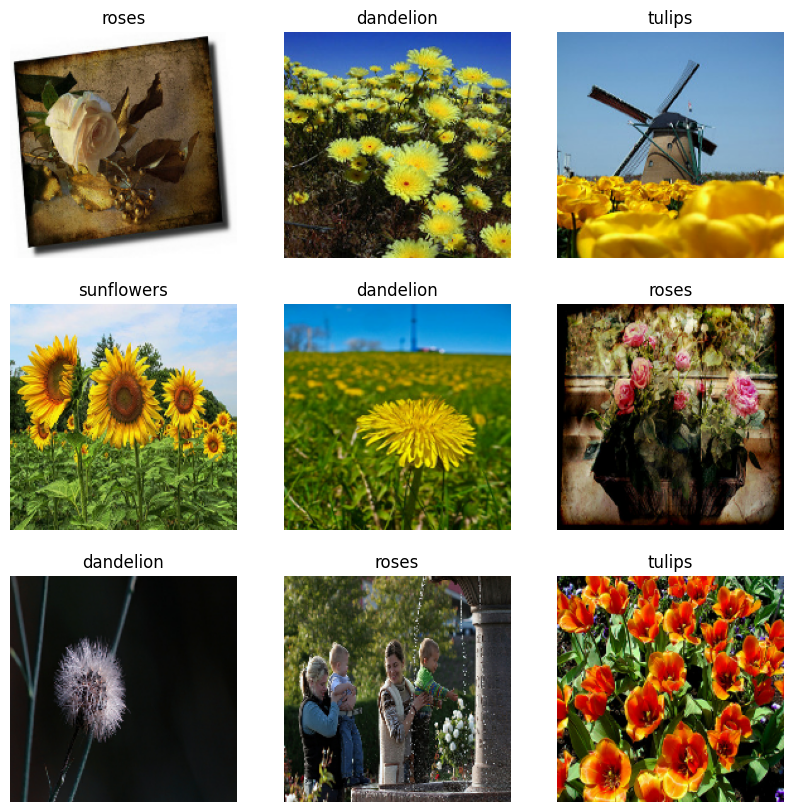

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Вы можете обучить модель, используя эти наборы данных, передав их в model.fit (показано далее в этом руководстве). Если хотите, вы также можете вручную перебрать набор данных и получить пакеты изображений:

In [ ]:
s = 0
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  s+=1
  if s == 3: break

# Если написать train_ds.take(1), то возьмем только 1 батч

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


image_batch представляет собой тензор формы (32, 180, 180, 3) . Это пакет из 32 изображений размером 180x180x3 (последний размер относится к цветовым каналам RGB). label_batch — это тензор формы (32,) , это соответствующие метки для 32 изображений.

Вы можете вызвать .numpy() для любого из этих тензоров, чтобы преобразовать их в numpy.ndarray .

Стандартизируйте данные

Значения канала RGB находятся в диапазоне [0, 255] . Это не идеально для нейронной сети; в общем, вы должны стремиться к тому, чтобы ваши входные значения были небольшими.

Здесь вы будете стандартизировать значения в диапазоне [0, 1] с помощью `tf.keras.layers.Rescaling:`

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Есть два способа использования этого слоя. Вы можете применить его к набору данных, вызвав `Dataset.map :`

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Или вы можете включить слой в определение вашей модели, чтобы упростить развертывание. Здесь вы будете использовать второй подход.

Примечание. Если вы хотите масштабировать значения пикселей до [-1,1] , вы можете вместо этого написать `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Примечание. Ранее вы изменяли размер изображений с помощью аргумента `image_size tf.keras.utils.image_dataset_from_directory` . Если вы хотите включить логику изменения размера в свою модель, вы можете использовать слой `tf.keras.layers.Resizing`

Настройте набор данных для производительности

Обязательно используйте предварительную выборку с буферизацией, чтобы вы могли получать данные с диска, не блокируя ввод-вывод. Вот два важных метода, которые вы должны использовать при загрузке данных:

Dataset.cache хранит изображения в памяти после их загрузки с диска в течение первой эпохи. Это гарантирует, что набор данных не станет узким местом при обучении вашей модели. Если ваш набор данных слишком велик, чтобы поместиться в память, вы также можете использовать этот метод для создания производительного кэша на диске.

Dataset.prefetch перекрывает предварительную обработку данных и выполнение модели во время обучения.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Обучить модель

Для полноты вы покажете, как обучить простую модель, используя только что подготовленные наборы данных.

Последовательная модель состоит из трех блоков свертки ( `tf.keras.layers.Conv2D` ) с максимальным объединяющим слоем ( `tf.keras.layers.MaxPooling2D` ) в каждом из них. Существует полносвязный слой ( `tf.keras.layers.Dense` ) со 128 единицами поверх него, который активируется функцией активации ReLU ( `relu` ). Эта модель никоим образом не настраивалась — цель состоит в том, чтобы показать вам механику с использованием только что созданных наборов данных. Учебник по [классификации изображений](https://www.tensorflow.org/tutorials/images/classification?hl=ru) .

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Выберите оптимизатор `tf.keras.optimizers.Adam` и функцию потерь `tf.keras.losses`.`SparseCategoricalCrossentropy` . Чтобы просмотреть точность обучения и проверки для каждой эпохи обучения, передайте аргумент metrics в `Model.compile` .

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Примечание. Вы также можете написать собственный цикл обучения вместо использования Model.fit . Чтобы узнать больше, посетите учебник [Создание тренировочного цикла с нуля](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=ru) .


Вы можете заметить, что точность проверки низка по сравнению с точностью обучения, что указывает на переоснащение вашей модели. Вы можете узнать больше о переоснащении и о том, как его уменьшить в этом [уроке](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ru) .



---



## Использование tf.data для более тонкого контроля

Вышеупомянутая утилита предварительной обработки Keras — `tf.keras.utils.image_dataset_from_directory` — это удобный способ создать `tf.data.Dataset` из каталога изображений.

Для более точного контроля вы можете написать свой собственный входной конвейер, используя `tf.data` . В этом разделе показано, как это сделать, начиная с путей к файлам из загруженного ранее файла TGZ.

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/3665455426_9cd1c3af4a_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/16967372357_15b1b9a812_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/9431896325_23bf6e8761.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/4265711814_9a006ee5b8.jpg'
b'/root/.keras/datasets/flower_photos/tulips/8838347159_746d14e6c1_m.jpg'


Древовидную структуру файлов можно использовать для составления списка class_names .

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Разделите набор данных на наборы для обучения и проверки:

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Вы можете распечатать длину каждого набора данных следующим образом:

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Напишите короткую функцию, которая преобразует путь к файлу в пару (img, label) :

In [ ]:
for i in train_ds.take(1):
  a = tf.strings.split(i, '/')[-2] == 'tulips'
  print(a)

tf.Tensor(True, shape=(), dtype=bool)


In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Используйте `Dataset.map` для создания набора данных пар image, label :

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


Настройка набора данных для повышения производительности

Чтобы обучить модель с этим набором данных, вам понадобятся данные:

- Чтобы хорошо перетасовать.
- Для пакетирования.
- Партии должны быть доступны как можно скорее.

Эти функции можно добавить с помощью API tf.data . Дополнительные сведения см. в руководстве по производительности входного конвейера .

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Визуализируйте данные

Вы можете визуализировать этот набор данных аналогично тому, который вы создали ранее:

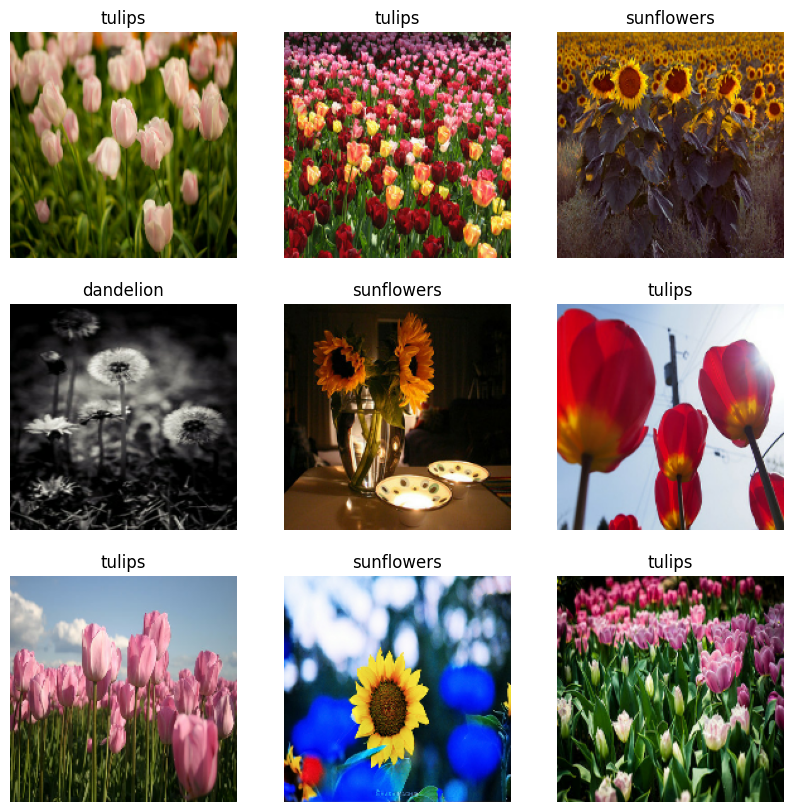

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Продолжить обучение модели


Теперь вы вручную создали набор `tf.data.Dataset` , аналогичный тому, который был создан с помощью `tf.keras.utils.image_dataset_from_directory` выше. С ним вы можете продолжить обучение модели. Как и прежде, вы будете тренироваться всего несколько эпох, чтобы сократить время бега.

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Вы можете найти полный пример работы с набором данных Flowers и наборами данных TensorFlow, посетив учебник по [расширению данных](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ru) .

[как добавить увеличение данных](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ru)